In this notebook, I will demonstrate how to train an A2C algorithm using both fastText and custom embeddings as item representations, along with a GRU-based feature extractor.

In [ ]:
%%capture
!pip install gymnasium stable-baselines3 'shimmy>=2.0'

In [ ]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
from collections import Counter
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

from stable_baselines3 import A2C
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.env_util import make_vec_env

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from reward_simulator import StateActionRewardProcessor
from custom_env import RecurrentRecommendationEnv
from utils import dcg_at_k, ndcg_at_k, precision_at_k, recall_at_k, is_hit, calc_for_user, load_custom_embeddings, load_fasttext_embeddings, GRUFeatureExtractor

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir = '/content/drive/MyDrive/ML/Reinforcement Learning/Final project/MIND'

In [ ]:
merged_behaviors_path = os.path.join(project_dir, 'processed_data/merged_behaviors_train.csv')
merged_behaviors = pd.read_csv(merged_behaviors_path)

embeddings_path_fasttext = os.path.join(project_dir, 'embeddings/news_train_fasttext_embeddings.pkl')
embeddings_path_custom = os.path.join(project_dir, 'embeddings/news_train_custom_embeddings.pkl')

processor = StateActionRewardProcessor(merged_behaviors, embeddings_path_fasttext=embeddings_path_fasttext, embeddings_path_custom=embeddings_path_custom, alpha=0.5)

embeddings_dict = processor.embeddings_dict

Processing sessions: 100%|██████████| 49108/49108 [00:22<00:00, 2135.26it/s]
Computing state-action embeddings: 1361705it [03:54, 5817.71it/s]


In [ ]:
EMB_DIM = embeddings_dict[next(iter(embeddings_dict))].shape[0]

In [ ]:
EMB_DIM

128

In [ ]:
env = RecurrentRecommendationEnv(merged_behaviors, embeddings_dict, processor, emb_dim=EMB_DIM)

In [1]:
policy_kwargs = dict(features_extractor_class=GRUFeatureExtractor, features_extractor_kwargs={"emb_dim": EMB_DIM, "hidden_dim": 64})

model = A2C(ActorCriticPolicy, env, policy_kwargs=policy_kwargs, tensorboard_log="./a2c_tensorboard/", verbose=1)

In [2]:
model.learn(total_timesteps = 20_000)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./a2c_tensorboard/

In [ ]:
event_path = '/content/a2c_tensorboard/A2C_1/events.out.tfevents.1743160716.07bca440ff0c.186.0'
event_acc = EventAccumulator(event_path)
event_acc.Reload()

scalar_name = "rollout/ep_rew_mean"
reward_scalars = event_acc.Scalars(scalar_name)

scalar_name = "rollout/ep_len_mean"
length_scalars = event_acc.Scalars(scalar_name)

reward_df = pd.DataFrame([(s.step, s.wall_time, s.value) for s in reward_scalars], columns=["Step", "WallTime", "Value"])
length_df = pd.DataFrame([(s.step, s.wall_time, s.value) for s in length_scalars], columns=["Step", "WallTime", "Value"])

reward_path = os.path.join(project_dir, 'results/gru_a2c_fasttext_custom_emb_rewards.csv')
length_path = os.path.join(project_dir, 'results/gru_a2c_fasttext_custom_emb_lengths.csv')

reward_df.to_csv(reward_path, index=False)
length_df.to_csv(length_path, index=False)

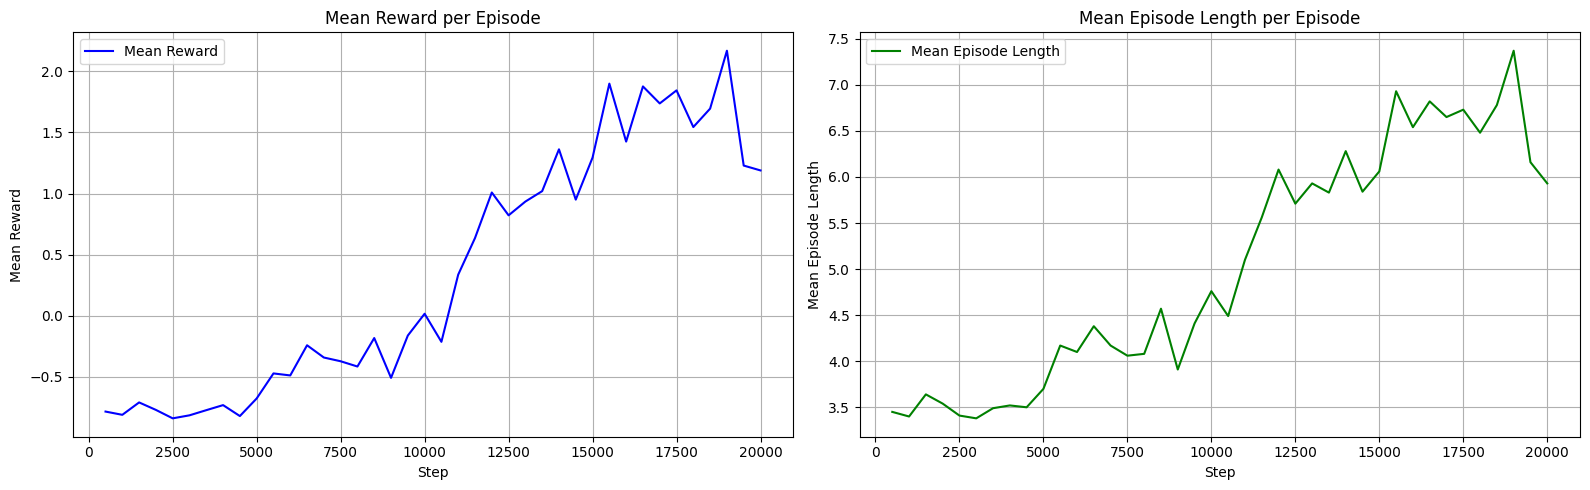

In [ ]:
reward_df = pd.read_csv(reward_path)
length_df = pd.read_csv(length_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(reward_df["Step"], reward_df["Value"], label="Mean Reward", color='b')
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Mean Reward")
axes[0].set_title("Mean Reward per Episode")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(length_df["Step"], length_df["Value"], label="Mean Episode Length", color='g')
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Mean Episode Length")
axes[1].set_title("Mean Episode Length per Episode")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# model.save("gru_a2c_fasttext_custom_emb")

In [ ]:
# model = A2C.load("gru_a2c_fasttext_custom_emb.zip")

## Predict for a single user

In [ ]:
news_train_path = os.path.join(project_dir, 'MINDsmall_train/news.tsv')
news_train = pd.read_csv(news_train_path, sep='\t', header=None, names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])

In [3]:
merged_behaviors['user_id'].values[:100]

In [ ]:
# Choose user

USER_ID = 'U9993'

In [ ]:
user_hist = merged_behaviors[merged_behaviors['user_id'] == USER_ID].iloc[0, 1].split()
user_imressions = [i.split('-')[0] for i in merged_behaviors[merged_behaviors['user_id'] == USER_ID].iloc[0, 2].split()]

In [ ]:
user_hist[:5]

['N47458', 'N14114']

In [ ]:
user_imressions[:5]

['N28918', 'N53515', 'N34869', 'N37204', 'N15574']

In [ ]:
obs = env.reset(user_hist)

In [4]:
print(env.user_history)
for i in range(10):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"New history: {env.user_history}")
    print(f"Recommended: {env.recommended}")
    print(f"Rewards: {env.rewards}")

In [ ]:
news_train[news_train['news_id'].isin(user_hist)]

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
20912,N14114,entertainment,news,Christopher Dennis Dies: 'Hollywood Superman' ...,Hollywood Boulevard is in mourning for a lost ...,https://assets.msn.com/labs/mind/AAJY0Kz.html,"[{""Label"": ""Jimmy Kimmel Live!"", ""Type"": ""W"", ...","[{""Label"": ""Hollywood Boulevard"", ""Type"": ""S"",..."
23231,N47458,news,newscrime,"1 dead, 2 injured, suspect still at large afte...",Three employees were shot Wednesday evening at...,https://assets.msn.com/labs/mind/AAJZvuH.html,"[{""Label"": ""Church's Chicken"", ""Type"": ""O"", ""W...","[{""Label"": ""Church's Chicken"", ""Type"": ""O"", ""W..."


In [ ]:
news_train[news_train['news_id'].isin(env.recommended)]

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
631,N35791,health,weightloss,"Ways to Lose Weight: 36 Fast, Easy Tips","If you're trying to drop a few pounds fast, th...",https://assets.msn.com/labs/mind/AAINwgt.html,[],[]
2416,N60954,finance,financenews,RTD Proposes Cutting Service Due To Operator S...,After years of struggling to combat an operato...,https://assets.msn.com/labs/mind/AAJ0VFr.html,"[{""Label"": ""RTD Bus & Rail"", ""Type"": ""U"", ""Wik...","[{""Label"": ""RTD Bus & Rail"", ""Type"": ""U"", ""Wik..."
6304,N13411,health,weightloss,"Jess Lost 145 Pounds, Went From a Size 22 to a...",Jessica Messina says she was overweight from t...,https://assets.msn.com/labs/mind/AAHn6u1.html,[],[]
6499,N44369,news,newsworld,More Russian military police arrive in Syria u...,More Russian military police arrive in Syria u...,https://assets.msn.com/labs/mind/AAJkve5.html,"[{""Label"": ""Syria"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Syria"", ""Type"": ""G"", ""WikidataId"":..."
7791,N7101,news,newsworld,"Thousands in Germany, France protest Turkish p...",Thousands of people in the German city of Colo...,https://assets.msn.com/labs/mind/AAJ1R8I.html,"[{""Label"": ""Syria"", ""Type"": ""G"", ""WikidataId"":...","[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""..."
9606,N48862,news,newsworld,"As Iraq and Lebanon protests flare, Iran cling...",Iran has worked to turn sweeping anti-governme...,https://assets.msn.com/labs/mind/AAJLIHL.html,"[{""Label"": ""Iraq"", ""Type"": ""G"", ""WikidataId"": ...","[{""Label"": ""Iraq"", ""Type"": ""G"", ""WikidataId"": ..."
9859,N61017,news,newsworld,Lebanon protesters block roads to keep revolt ...,Lebanese demonstrators set up barricades and p...,https://assets.msn.com/labs/mind/AAJsx9f.html,"[{""Label"": ""Lebanon"", ""Type"": ""G"", ""WikidataId...",[]
10128,N52574,news,newsworld,U.S. senators press for sanctions on Turkey if...,U.S. senators press for sanctions on Turkey if...,https://assets.msn.com/labs/mind/AAJXD1J.html,"[{""Label"": ""Syrian Civil War ceasefires"", ""Typ...","[{""Label"": ""Syrian Civil War ceasefires"", ""Typ..."
12204,N59932,news,newsworld,"North Korea says U.S., South Korea must presen...","North Korea says U.S., South Korea must presen...",https://assets.msn.com/labs/mind/AAJ6dBC.html,"[{""Label"": ""North Korea"", ""Type"": ""G"", ""Wikida...","[{""Label"": ""North Korea"", ""Type"": ""G"", ""Wikida..."
18288,N729,health,weightloss,How One Woman Lost 90 Pounds and Improved Her ...,"After Hurricane Katrina, everything changed fo...",https://assets.msn.com/labs/mind/AAJByFK.html,"[{""Label"": ""Hurricane Katrina"", ""Type"": ""E"", ""...","[{""Label"": ""Hurricane Katrina"", ""Type"": ""E"", ""..."


In [ ]:
indices = np.where(np.array(env.rewards) == 1)
will_click = np.array(env.recommended)[indices]

In [5]:
news_train[news_train['news_id'].isin(will_click)]

## Measuring quality on train and evaluation sets

### train

In [ ]:
ndcg_scores = []
precision_scores = []
recall_scores = []
hits = []

for USER_ID in merged_behaviors['user_id'].sample(n=1000, random_state=99):
    ndcg_score, precision_score, recall_score, hit_score = calc_for_user(USER_ID, merged_behaviors, 12, 3, 10, env, model)

    ndcg_scores.append(ndcg_score)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    hits.append(hit_score)

In [6]:
print(f"Mean NDCG: {round(np.mean(ndcg_scores), 3)}")
print(f"Mean precision: {round(np.mean(precision_scores), 3)}")
print(f"Mean recall: {round(np.mean(recall_scores), 3)}")
print(f"Mean hit rate: {round(np.mean(hits), 3)}")

### dev

In [ ]:
embeddings_fasttext_dev_path = os.path.join(project_dir, 'embeddings/news_dev_fasttext_embeddings.pkl')
embeddings_fasttext_dev_dict = load_fasttext_embeddings(embeddings_fasttext_dev_path)

embeddings_custom_dev_path = os.path.join(project_dir, 'embeddings/news_dev_custom_embeddings.pkl')
embeddings_custom_dev_dict = load_custom_embeddings(embeddings_custom_dev_path)

embeddings_dev_dict = {}

all_keys = embeddings_fasttext_dev_dict.keys() | embeddings_custom_dev_dict.keys()

for key in all_keys:

    emb_list = []

    if key in embeddings_fasttext_dev_dict:
        emb_list.append(embeddings_fasttext_dev_dict[key])
    if key in embeddings_custom_dev_dict:
        emb_list.append(embeddings_custom_dev_dict[key])

    if emb_list:
        embeddings_dev_dict[key] = np.concatenate(emb_list)

behaviors_dev_path = os.path.join(project_dir, 'processed_data/merged_behaviors_dev.csv')
merged_behaviors_dev = pd.read_csv(behaviors_dev_path)

In [ ]:
merged_behaviors_dev.head()

,user_id,history,impressions
0,U1,N23571 N58267 N25682 N10646 N32607 N57737 N523...,N14637-0 N20036-1
1,U10,N27612 N36699 N64777 N9120 N9803 N57967 N2945,N33397-0 N46917-0 N11930-0 N58612-0 N47612-0 N...
2,U10000,N10059 N46978 N53234 N3345 N3345 N9155 N9653 N...,N29393-0 N20036-0 N30290-0 N31958-1 N23513-0 N...
3,U10002,N27448 N10059 N28467 N64777 N18881 N33117 N129...,N29862-0 N60724-0 N42844-0 N6916-0 N26485-0 N2...
4,U10004,N38118 N55805 N43482 N15402 N15627 N18870 N526...,N29379-0 N5472-0 N36779-1 N20036-0 N31958-0 N4...


In [ ]:
dev_env = RecurrentRecommendationEnv(merged_behaviors_dev, embeddings_dev_dict, processor, emb_dim=EMB_DIM)

In [ ]:
ndcg_scores = []
precision_scores = []
recall_scores = []
hits = []

for USER_ID in merged_behaviors_dev['user_id'].sample(n=1000, random_state=99):
    ndcg_score, precision_score, recall_score, hit_score = calc_for_user(USER_ID, merged_behaviors_dev, 12, 3, 10, dev_env, model)

    ndcg_scores.append(ndcg_score)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    hits.append(hit_score)

In [7]:
print(f"Mean NDCG: {round(np.mean(ndcg_scores), 3)}")
print(f"Mean precision: {round(np.mean(precision_scores), 3)}")
print(f"Mean recall: {round(np.mean(recall_scores), 3)}")
print(f"Mean hit rate: {round(np.mean(hits), 3)}")